Import necessary libraries

In [1]:
# Import necessary libraries
!pip install tensorflow-gpu
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import random
import tensorflow_datasets as tfds 
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
!pip install keras-tuner
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from kerastuner.tuners import RandomSearch
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.8 MB/s eta 0:00:00


<ipython-input-1-ddc23310b50e>:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Data Visualization

Number of training samples: 112800
Number of testing samples: 18800


<ipython-input-3-63f9dcca79e2>:25: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  plt.imshow(img.T.squeeze(), cmap="gray")


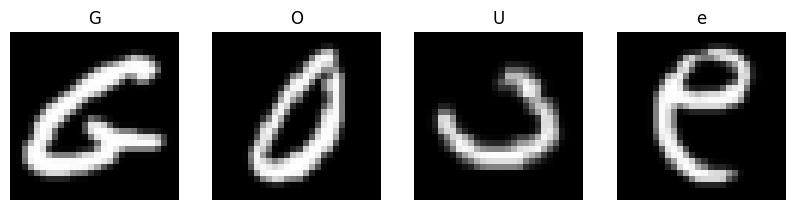

39


In [3]:
# Import necessary libraries

# Download and load the dataset
train_dataset = torchvision.datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=torchvision.transforms.ToTensor())


# Understand and visualize the dataset
print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))

#Mapping
with open('emnist-balanced-mapping.txt', 'r') as f:
    mapping = {int(line.strip().split()[0]): int(line.strip().split()[1]) for line in f.readlines()}

# Visualize some samples from the dataset
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 1
for i in range(1, cols * rows + 1):
    img_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[img_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(chr(mapping[label]))
    plt.axis("off")
    plt.imshow(img.T.squeeze(), cmap="gray")
plt.show()
print(label)

In [5]:
# Load EMNIST data
train_dataset, test_dataset = tfds.load("emnist/balanced", split=["train", "test"], as_supervised=True)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))

# Split validation dataset from the train_data
validation_split = 0.2
num_train_examples = tf.data.experimental.cardinality(train_dataset).numpy()
num_validation_examples = int(num_train_examples * validation_split)
train_datas = train_dataset.skip(num_validation_examples)
validation_dataset = train_dataset.take(num_validation_examples)
# Preprocessing function for EMNIST data
def pre_pro(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=(28, 28))
    return image, label

# Preprocessing function for EMNIST data
def pre_pro1(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=(28, 28))  
    label = tf.one_hot(label, depth=47)
    return image, label

# Apply preprocessing to EMNIST data
train_data = train_datas.map(lambda x, y: pre_pro(x, y))
test_data = test_dataset.map(lambda x, y: pre_pro(x, y))
validation_data = validation_dataset.map(lambda x, y: pre_pro(x, y))

train_data1 = train_datas.map(lambda x, y: pre_pro1(x, y))
test_data1 = test_dataset.map(lambda x, y: pre_pro1(x, y))
validation_data1 = validation_dataset.map(lambda x, y: pre_pro1(x, y))


print("Number of training samples after validation split:", len(train_data))
print("Number of validation samples:", len(validation_data))
print("Number of testing samples:", len(test_data))

plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['image.cmap'] = 'gray'

SEED_VALUE = 42
 # Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/3.0.0.incompleteC8985A/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/3.0.0.incompleteC8985A/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/balanced/3.0.0. Subsequent calls will reuse this data.
Number of training samples: 112800
Number of testing samples: 18800
Number of training samples after validation split: 90240
Number of validation samples: 22560
Number of testing samples: 18800


*MLP*

Instantiate the model.

In [ ]:
# Set hyperparameters
learning_rate = 0.01
num_classes = 47
dropout_rate = 0.5
l2_regularization = 0.01

# Initial MLP model.
init_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(32, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(32, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(num_classes, activation="softmax")])
# Define learning rate scheduler
# step decay
def step_decay(epochs):
    initial_lr = 0.1
    factor = 0.1
    drop_every = 10
    lr = initial_lr * (factor ** np.floor((1 + epochs) / drop_every))
    return lr
# Compile model
init_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),loss="sparse_categorical_crossentropy",metrics=["accuracy"])

# Train MLP model
Init_Performance = init_model.fit(train_data.batch(128), epochs=10, validation_data = validation_data.batch(128),
                            callbacks=[LearningRateScheduler(step_decay), EarlyStopping(patience=5)])
plt.plot(Init_Performance.history['accuracy'], label='Training Accuracy')
plt.plot(Init_Performance.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy of Initial MLP Model")
plt.legend()
plt.show()

plt.plot(Init_Performance.history['loss'], label='Training Loss')
plt.plot(Init_Performance.history['val_loss'], label='Validation Loss')
plt.title("Loss of Initial MLP Model")
plt.legend()
plt.show()

# Evaluate the models
test_loss, test_acc = init_model.evaluate(test_data1.batch(128))
print('Initial MLP Model - Test loss:', test_loss, 'Test accuracy:', test_acc)


Learning rate schedulers 

In [ ]:
# Step decay
def step_decay(epoch):
    initial_lr = 0.1
    factor = 0.1
    drop_every = 10
    lr = initial_lr * (factor ** np.floor((1 + epoch) / drop_every))
    return lr

# Exponential decay
def exp_decay(epoch):
    initial_lr = 0.1
    decay_rate = 0.1
    lr = initial_lr * np.exp(-decay_rate * epoch)
    return lr

# Create the model
dk_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(47, activation='softmax')
])

# Define the optimizer with a learning rate of 0.1
opt = tf.keras.optimizers.SGD(learning_rate=0.1)

# Compile the model with the SGD optimizer and a loss function
dk_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# Set up the callbacks
step_decay_cb = tf.keras.callbacks.LearningRateScheduler(step_decay)
exp_decay_cb = tf.keras.callbacks.LearningRateScheduler(exp_decay)

# Train the model with step decay
performance_step_decay = dk_model.fit(train_data.batch(128), epochs=10, validation_data=validation_data.batch(128), callbacks=[step_decay_cb])

# Train the model with exponential decay
performance_exp_decay = dk_model.fit(train_data.batch(128), epochs=10, validation_data=validation_data.batch(128), callbacks=[exp_decay_cb])

# Plot the training and validation accuracy for both learning rate schedules
plt.plot(performance_step_decay.history['accuracy'], label='Step Decay Training Accuracy')
plt.plot(performance_step_decay.history['val_accuracy'], label='Step Decay Validation Accuracy')
plt.plot(performance_exp_decay.history['accuracy'], label='Exp Decay Training Accuracy')
plt.plot(performance_exp_decay.history['val_accuracy'], label='Exp Decay Validation Accuracy')
plt.title("Accuracy of Model with Learning rate schedules")
plt.legend()
plt.show()

# Plot the training and validation loss for both learning rate schedules
plt.plot(performance_step_decay.history['loss'], label='Step Decay Training Loss')
plt.plot(performance_step_decay.history['val_loss'], label='Step Decay Validation Loss')
plt.plot(performance_exp_decay.history['loss'], label='Exp Decay Training Loss')
plt.plot(performance_exp_decay.history['val_loss'], label='Exp Decay Validation Loss')
plt.title("Loss of Model with Learning rate schedules")
plt.legend()
plt.show()



Choosing Best Optimizer

In [ ]:

# Define the MLP architecture
opt_model = keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(47, activation='softmax')])

# Define the list of optimizers to try
optimizers = [tf.keras.optimizers.SGD(), 
              tf.keras.optimizers.Adam(), 
              tf.keras.optimizers.RMSprop()]

# Train the model with each optimizer and evaluate its performance on the training data
optimizer_names = [type(optimizer).__name__ for optimizer in optimizers]
train_accs = []
train_losss = []
for optimizer in optimizers:
    opt_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    opt_model.fit(train_data.batch(128), epochs=10, batch_size=64, verbose=1)
    train_loss, train_acc = opt_model.evaluate(validation_data.batch(128), verbose=0)
    train_accs.append(train_acc)
    train_losss.append(train_loss)
    print('Optimizer:', type(optimizer).__name__, '- Training Loss:', train_loss, '- Training Accuracy:', train_acc)

# Plot the training accuracy for each optimizer
plt.bar(optimizer_names, train_accs)
plt.title('Training Accuracy for Different Optimizers')
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.show()

# Plot the training accuracy for each optimizer
plt.bar(optimizer_names, train_losss)
plt.title('Training Loss for Different Optimizers')
plt.xlabel('Optimizer')
plt.ylabel('Loss')
plt.ylim([0.0, 1.0])
plt.show()

Choosing best Activation function


In [ ]:

# Define the model with relu
def model_relu():
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28, 28, 1)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(47, activation='softmax')])
    return model

# Define the model with sigmoid
def model_sigmoid():
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28, 28, 1)),
        keras.layers.Dense(128, activation='sigmoid'),
        keras.layers.Dense(128, activation='sigmoid'),
        keras.layers.Dense(128, activation='sigmoid'),
        keras.layers.Dense(47, activation='softmax')])
    return model

# Define the model with tanh
def model_tanh():
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28, 28, 1)),
        keras.layers.Dense(128, activation='tanh'),
        keras.layers.Dense(128, activation='tanh'),
        keras.layers.Dense(128, activation='tanh'),
        keras.layers.Dense(47, activation='softmax')])
    return model
# Create the models
model_relu = model_relu()
model_sigmoid = model_sigmoid()
model_tanh = model_tanh()

# Compile the models
model_relu.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model_sigmoid.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model_tanh.compile(optimizer=keras.optimizers.Adam(),loss=keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

# Train the models
performance_relu = model_relu.fit(train_data1.batch(128), epochs=10, validation_data = validation_data1.batch(128))
performance_sigmoid = model_sigmoid.fit(train_data1.batch(128), epochs=10, validation_data = validation_data1.batch(128))
performance_tanh = model_tanh.fit(train_data1.batch(128), epochs=10, validation_data=validation_data1.batch(128))

# Plot the training accuracy for each Activation function
plt.plot(performance_relu.history['accuracy'], label='Relu Training Accuracy')
plt.plot(performance_relu.history['val_accuracy'], label='Relu Validation Accuracy')
plt.plot(performance_sigmoid.history['accuracy'], label='Sigmoid Training Accuracy')
plt.plot(performance_sigmoid.history['val_accuracy'], label='Sigmoid Validation Accuracy')
plt.plot(performance_tanh.history['accuracy'], label='Tanh Training Accuracy')
plt.plot(performance_tanh.history['val_accuracy'], label='Tanh Validation Accuracy')
plt.title('Accuracy of each Activation functions')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training Loss for each Activation function
plt.plot(performance_relu.history['loss'], label='Relu Training Loss')
plt.plot(performance_relu.history['val_loss'], label='Relu Validation Loss')
plt.plot(performance_sigmoid.history['loss'], label='Sigmoid Training Loss')
plt.plot(performance_sigmoid.history['val_loss'], label='Sigmoid Validation Loss')
plt.plot(performance_tanh.history['loss'], label='Tanh Training Loss')
plt.plot(performance_tanh.history['val_loss'], label='Tanh Validation Loss')
plt.title('Loss of each Activation functions')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the models
test_loss, test_acc = model_relu.evaluate(validation_data1.batch(128))
print('Model relu - Val loss:', test_loss, 'Val accuracy:', test_acc)

test_loss, test_acc = model_sigmoid.evaluate(validation_data1.batch(128))
print('Model sigmoid - Val loss:', test_loss, 'Val accuracy:', test_acc)

test_loss, test_acc = model_tanh.evaluate(validation_data1.batch(128))
print('Model tanh - Val loss:', test_loss, 'Val accuracy:', test_acc)

With and without Dropout

In [ ]:
# Define the model architecture with Dropout regularization
def model_with_dropout():
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28, 28, 1)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(47, activation='softmax')])
    return model

# Define the model architecture without Dropout regularization
def model_without_dropout():
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28, 28, 1)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(47, activation='softmax')])
    return model

# Compile the model with and without Dropout regularization
model_with_dropout = model_with_dropout()
model_without_dropout = model_without_dropout()
model_with_dropout.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_without_dropout.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the models
epochs = 10
performance_with_dropout = model_with_dropout.fit(train_data1.batch(128), epochs=epochs, validation_data=validation_data1.batch(128))
performance_without_dropout = model_without_dropout.fit(train_data1.batch(128), epochs=epochs, validation_data=validation_data1.batch(128))

# Plot the trainind accuracy model with and without Dropout regularization
plt.plot(performance_with_dropout.history['accuracy'], label='With Dropout Training Accuracy')
plt.plot(performance_with_dropout.history['val_accuracy'], label='With Dropout Validation Accuracy')
plt.plot(performance_without_dropout.history['accuracy'], label='Without Dropout Training Accuracy')
plt.plot(performance_without_dropout.history['val_accuracy'], label='With Dropout Validation Accuracy')
plt.title('Accuracy of model with and without Dropout')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot the trainind loss model with and without Dropout regularization
plt.plot(performance_with_dropout.history['loss'], label='With Dropout Training loss')
plt.plot(performance_with_dropout.history['val_loss'], label='With Dropout Validation loss')
plt.plot(performance_without_dropout.history['loss'], label='Without Dropout Training loss')
plt.plot(performance_without_dropout.history['val_loss'], label='With Dropout Validation loss')
plt.title('Loss of model with and without Dropout')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the models
test_loss, test_acc = model_relu.evaluate(validation_data1.batch(128))
print('Model with Dropout - Val loss:', test_loss, 'Val accuracy:', test_acc)

test_loss, test_acc = model_sigmoid.evaluate(validation_data1.batch(128))
print('Model without Dropout - Val loss:', test_loss, 'Val accuracy:', test_acc)



L1 & L2 regularization

In [ ]:
# Define the models
def model(regularizer=None):
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28, 28,1)),
        keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer),
        keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer),
        keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer),
        keras.layers.Dense(47, activation='softmax')])
    return model

model_no_reg = model()
model_l1_reg = model(keras.regularizers.l1(0.01))
model_l2_reg = model(keras.regularizers.l2(0.01))

# Compile the models
model_no_reg.compile(optimizer=keras.optimizers.Adam(),loss=keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
model_l1_reg.compile(optimizer=keras.optimizers.Adam(),loss=keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
model_l2_reg.compile(optimizer=keras.optimizers.Adam(),loss=keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

# Train the models
performance_no_reg = model_no_reg.fit(train_data.batch(128), epochs=10, validation_data=validation_data.batch(128))
performance_l1_reg = model_l1_reg.fit(train_data.batch(128), epochs=10, validation_data=validation_data.batch(128))
performance_l2_reg = model_l2_reg.fit(train_data.batch(128), epochs=10, validation_data=validation_data.batch(128))

# Plot the trainind accuracy model with and without L1 & L2 regularization
plt.plot(performance_no_reg.history['accuracy'], label='No Reg Training Accuracy')
plt.plot(performance_no_reg.history['val_accuracy'], label='No Reg Validation Accuracy')
plt.plot(performance_l1_reg.history['accuracy'], label='L1 Reg Training Accuracy')
plt.plot(performance_l1_reg.history['val_accuracy'], label='L1 Reg Validation Accuracy')
plt.plot(performance_l2_reg.history['accuracy'], label='L2 Reg Training Accuracy')
plt.plot(performance_l2_reg.history['val_accuracy'], label='L2 Reg Validation Accuracy')
plt.title('Accuracy of model with and without L1 & L2')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot the trainind loss model with and without L1 & L2 regularization
plt.plot(performance_no_reg.history['loss'], label='No Reg Training loss')
plt.plot(performance_no_reg.history['val_loss'], label='No Reg Validation loss')
plt.plot(performance_l1_reg.history['loss'], label='L1 Reg Training loss')
plt.plot(performance_l1_reg.history['val_loss'], label='L1 Reg Validation loss')
plt.plot(performance_l2_reg.history['loss'], label='L2 Reg Training loss')
plt.plot(performance_l2_reg.history['val_loss'], label='L2 Reg Validation loss')
plt.title('Loss of model with and without L1 & L2')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the models
test_loss, test_acc = model_no_reg.evaluate(validation_data.batch(128))
print('Model without regularization - Val loss:', test_loss, 'Val accuracy:', test_acc)
test_loss, test_acc = model_l1_reg.evaluate(validation_data.batch(128))
print('Model with L1 regularization - Val loss:', test_loss, 'Val accuracy:', test_acc)
test_loss, test_acc = model_l2_reg.evaluate(validation_data.batch(128))
print('Model with L2 regularization - Val loss:', test_loss, 'Val accuracy:', test_acc)


With and Without BatchNormalization

In [ ]:
# Define the model architecture without Batch Normalization
def model_without_bn():
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28, 28, 1)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(47, activation='softmax')])
    return model

# Define the model architecture with Batch Normalization
def model_with_bn():
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28, 28, 1)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(47, activation='softmax')])
    return model

# Create the models
model_without_bn = model_without_bn()
model_with_bn = model_with_bn()

# Compile the models
model_without_bn.compile(optimizer=keras.optimizers.adam(),loss=keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
model_with_bn.compile(optimizer=keras.optimizers.adam(),loss=keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

# Train the models
performance_without_bn = model_without_bn.fit(train_data1.batch(128),epochs=10,validation_data=validation_data1.batch(128))
performance_with_bn = model_with_bn.fit(train_data1.batch(128),epochs=10,validation_data=validation_data1.batch(128))

# Plot the trainind accuracy model with and without Batch Normalization
plt.plot(performance_with_bn.history['accuracy'], label='With Batch Normalization Training Accuracy')
plt.plot(performance_with_bn.history['val_accuracy'], label='With Batch Normalization Validation Accuracy')
plt.plot(performance_without_bn.history['accuracy'], label='Without Batch Normalization Training Accuracy')
plt.plot(performance_without_bn.history['val_accuracy'], label='Without Batch Normalization Validation Accuracy')
plt.title('Accuracy of model with and without Batch Normalization')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot the trainind accuracy model with and without Batch Normalization
plt.plot(performance_with_bn.history['loss'], label='With Batch Normalization Training loss')
plt.plot(performance_with_bn.history['val_loss'], label='With Batch Normalization Validation loss')
plt.plot(performance_without_bn.history['accuracy'], label='Without Batch Normalization Training loss')
plt.plot(performance_without_bn.history['val_loss'], label='Without Batch Normalization Validation loss')
plt.title('Loss of model with and without Batch Normalization')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the models
test_loss, test_acc = model_without_bn.evaluate(validation_data1.batch(128))
print('Model without Batch Normalization - Val loss:', test_loss, 'Val accuracy:', test_acc)

test_loss, test_acc = model_with_bn.evaluate(validation_data1.batch(128))
print('Model with Batch Normalization - Val loss:', test_loss, 'Val accuracy:', test_acc)

Final Model

In [ ]:
 # Set hyperparameters
learning_rate = 0.01
num_classes = 47
dropout_rate = 0.2

# Final MLP model.
final_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (28, 28, 1)),
    tf.keras.layers.Dense(288, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(num_classes, activation="softmax")])
# Define learning rate scheduler
# Exponential decay
def exp_decay(epochs):
    initial_lr = 0.1
    decay_rate = 0.1
    lr = initial_lr * np.exp(-decay_rate * epochs)
    return lr
# Compile model
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),loss="categorical_crossentropy",metrics=["accuracy"])

# Train MLP model
performance = final_model.fit(train_data1.batch(128), epochs=10, validation_data = validation_data1.batch(128),
                            callbacks=[LearningRateScheduler(exp_decay), EarlyStopping(patience=5)])

plt.plot(performance.history['accuracy'], label='Training Accuracy')
plt.plot(performance.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy of Final MLP Model")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(Init_Performance.history['loss'], label='Training Loss')
plt.plot(Init_Performance.history['val_loss'], label='Validation Loss')
plt.title("Loss of Final MLP Model")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Hyperparameter Tuning

Epoch 1/10
705/705 [==============================] - 18s 16ms/step - loss: 1.6674 - accuracy: 0.5397 - val_loss: 2.5755 - val_accuracy: 0.6230 - lr: 0.1000
Epoch 2/10
705/705 [==============================] - 10s 14ms/step - loss: 1.1586 - accuracy: 0.6684 - val_loss: 0.9592 - val_accuracy: 0.7430 - lr: 0.0905
Epoch 3/10
705/705 [==============================] - 13s 18ms/step - loss: 0.9921 - accuracy: 0.7084 - val_loss: 0.8222 - val_accuracy: 0.7732 - lr: 0.0819
Epoch 4/10
705/705 [==============================] - 16s 22ms/step - loss: 0.9263 - accuracy: 0.7204 - val_loss: 0.7096 - val_accuracy: 0.7829 - lr: 0.0741
Epoch 5/10
705/705 [==============================] - 15s 21ms/step - loss: 0.7796 - accuracy: 0.7581 - val_loss: 0.6566 - val_accuracy: 0.8014 - lr: 0.0670
Epoch 6/10
705/705 [==============================] - 14s 20ms/step - loss: 0.7263 - accuracy: 0.7745 - val_loss: 0.6676 - val_accuracy: 0.7971 - lr: 0.0607
Epoch 7/10
705/705 [==============================] - 15s 

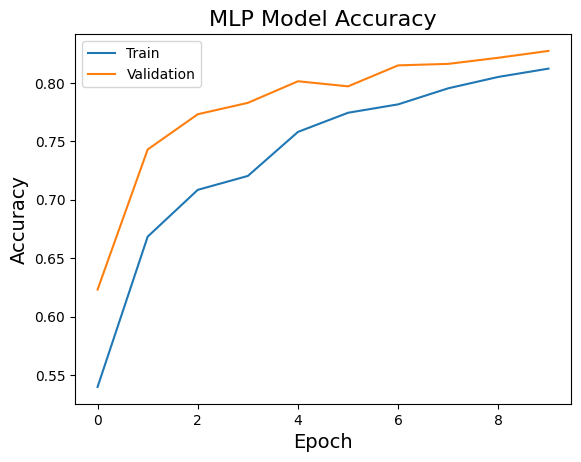

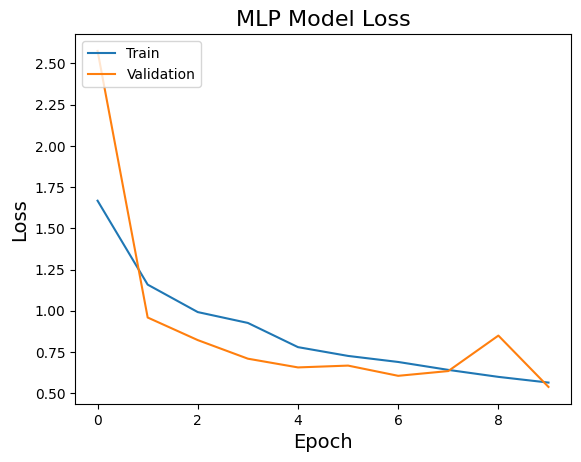

147/147 [==============================] - 1s 7ms/step - loss: 0.5541 - accuracy: 0.8226
Final MLP Model - Test loss: 0.5541408061981201 Test accuracy: 0.8225532174110413
147/147 [==============================] - 1s 6ms/step


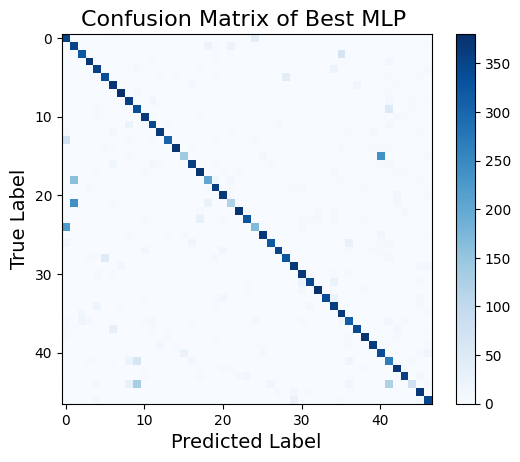

1/1 [==============================] - 0s 170ms/step


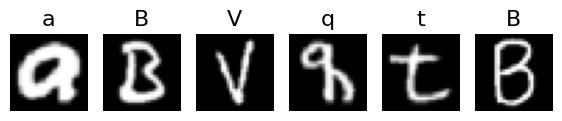

Classification report of best MLP model
               precision    recall  f1-score   support

           0       0.51      0.88      0.65       400
           1       0.46      0.87      0.60       400
           2       0.89      0.80      0.84       400
           3       0.93      0.93      0.93       400
           4       0.86      0.89      0.87       400
           5       0.85      0.84      0.85       400
           6       0.84      0.93      0.88       400
           7       0.95      0.95      0.95       400
           8       0.79      0.89      0.84       400
           9       0.62      0.84      0.71       400
          10       0.90      0.92      0.91       400
          11       0.88      0.86      0.87       400
          12       0.94      0.92      0.93       400
          13       0.93      0.76      0.84       400
          14       0.97      0.93      0.95       400
          15       0.83      0.35      0.49       400
          16       0.88      0.89      0

In [22]:
# Define the hyperparameters to search over
param_grid = {'learning_rate': [0.01, 0.001],'dropout_rate': [0.1, 0.2, 0.3],'num_layers': [2, 3, 4, 5],'units': [32, 64, 128, 256],}

# Define a function to build the MLP model with the specified hyperparameters
def final_model(hp):
    model = keras.Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    for i in range(hp.Int('num_layers', 2, 5)):
        model.add(Dense(units=hp.Int('units', 32, 256, step=32),activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_rate', 0.1, 0.3, step=0.1)))
    model.add(Dense(47, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001])),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

# Defining learning rate scheduler
# Exponential decay
def exp_decay(epochs):
    initial_lr = 0.1
    decay_rate = 0.1
    lr = initial_lr * np.exp(-decay_rate * epochs)
    return lr
# Define the tuner and perform the hyperparameter search
tuner = RandomSearch(final_model,objective='val_accuracy',max_trials=3,directory='my_dir',project_name='Emnist')
tuner.search(train_data1.batch(128), epochs=10, validation_data=validation_data1.batch(128), callbacks=[EarlyStopping(patience=5)])
# Retrieving the best hyperparameters and train the model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# print(best_hps)
model = final_model(best_hps)
performance = model.fit(train_data1.batch(128), epochs=10, validation_data=validation_data1.batch(128), callbacks=[LearningRateScheduler(exp_decay), EarlyStopping(patience=5)])
# print(best_hps)
# Plot the training and validation accuracy curves
plt.plot(performance.history['accuracy'])
plt.plot(performance.history['val_accuracy'])
plt.title('MLP Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss curves
plt.plot(performance.history['loss'])
plt.plot(performance.history['val_loss'])
plt.title('MLP Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the models
test_loss, test_acc = model.evaluate(test_data1.batch(128))
print('Final MLP Model - Test loss:', test_loss, 'Test accuracy:', test_acc)

# Make predictions on the test data
y_pred = model.predict(test_data1.batch(128))
y_pred = np.argmax(y_pred, axis=1) # Convert predictions from probabilities to class labels

# Get true labels from test data
y_true = []
for x, y in test_data1.batch(128):
    y_true.extend(np.argmax(y.numpy(), axis=1))

#classification report
clf_report=classification_report(y_true, y_pred)
print("Classification report of best MLP model\n", clf_report)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix of Best MLP ')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Printing Predicted model
preds = model.predict(test_data.batch(6).take(1))
y_preds = np.argmax(preds, axis=1)
imgs, y_tru = next(iter(test_data.batch(6)))
y_tru_np = y_tru.numpy()
figure = plt.figure(figsize=(7, 7))
for i in range(6):
    figure.add_subplot(1, 6, i+1)
    plt.axis("off")
    img_transpose = imgs[i].T.numpy()
    plt.imshow(img_transpose.squeeze())
    plt.title(chr(mapping[y_tru_np[i]]))
plt.show()

clf_report=classification_report(y_true, y_pred)
print("Classification report of best MLP model\n", clf_report)

*CNN*

Instantiate the model.

In [ ]:
# Set hyperparameters
learning_rate = 0.01
num_classes = 47
dropout_rate = 0.5
l2_regularization = 0.01

# Initial CNN model.
def cnn_model():
  model = Sequential([
  Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
  MaxPooling2D(pool_size=(2,2)),
  Conv2D(64, kernel_size=(3,3), activation='relu'),
  MaxPooling2D(pool_size=(2,2)),
  Flatten(),
  Dense(256, activation='relu'),
  Dense(47, activation='softmax')])
  return model
init_model = cnn_model()
# Define learning rate scheduler
# Exponential decay
def step_decay(epochs):
    initial_lr = 0.1
    factor = 0.1
    drop_every = 10
    lr = initial_lr * (factor ** np.floor((1 + epochs) / drop_every))
    return lr
# Compile model
init_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train MLP model
init_performance = init_model.fit(train_data.batch(128), epochs=10, validation_data = validation_data.batch(128),
                            callbacks=[LearningRateScheduler(step_decay), EarlyStopping(patience=5)])
plt.plot(init_performance.history['accuracy'], label='Training Accuracy')
plt.plot(init_performance.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy of Initial CNN Model")
plt.legend()
plt.show()

plt.plot(init_performance.history['loss'], label='Training Loss')
plt.plot(init_performance.history['val_loss'], label='Validation Loss')
plt.title("Loss of Initial CNN Model")
plt.legend()
plt.show()

Learning rate schedulers 


In [ ]:
# Step decay
def step_decay(epoch):
    initial_lr = 0.1
    factor = 0.1
    drop_every = 10
    lr = initial_lr * (factor ** np.floor((1 + epoch) / drop_every))
    return lr

# Exponential decay
def exp_decay(epoch):
    initial_lr = 0.1
    decay_rate = 0.1
    lr = initial_lr * np.exp(-decay_rate * epoch)
    return lr

# Create the model
def cnn_model():
  model = Sequential([
  Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
  MaxPooling2D(pool_size=(2,2)),
  Conv2D(64, kernel_size=(3,3), activation='relu'),
  MaxPooling2D(pool_size=(2,2)),
  Flatten(),
  Dense(256, activation='relu'),
  Dense(47, activation='softmax')
])
  return model
dk_model = cnn_model()

# Define the optimizer with a learning rate of 0.1
opt = tf.keras.optimizers.SGD(learning_rate=0.1)

# Compile the model with the SGD optimizer and a loss function
dk_model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# Set up the callbacks
step_decay_cb = tf.keras.callbacks.LearningRateScheduler(step_decay)
exp_decay_cb = tf.keras.callbacks.LearningRateScheduler(exp_decay)

# Train the model with step decay
performance_step_decay = dk_model.fit(train_data.batch(128), epochs=10, validation_data=validation_data.batch(128), callbacks=[step_decay_cb])

# Train the model with exponential decay
performance_exp_decay = dk_model.fit(train_data.batch(128), epochs=10, validation_data=validation_data.batch(128), callbacks=[exp_decay_cb])

# Plot the training and validation accuracy for both learning rate schedules
import matplotlib.pyplot as plt

# Plot the training and validation accuracy for both learning rate schedules
plt.plot(performance_step_decay.history['accuracy'], label='Step Decay Training Accuracy')
plt.plot(performance_step_decay.history['val_accuracy'], label='Step Decay Validation Accuracy')
plt.plot(performance_exp_decay.history['accuracy'], label='Exp Decay Training Accuracy')
plt.plot(performance_exp_decay.history['val_accuracy'], label='Exp Decay Validation Accuracy')
plt.title("Accuracy of Model with Learning rate schedules")
plt.legend()
plt.show()

# Plot the training and validation loss for both learning rate schedules
plt.plot(performance_step_decay.history['loss'], label='Step Decay Training Loss')
plt.plot(performance_step_decay.history['val_loss'], label='Step Decay Validation Loss')
plt.plot(performance_exp_decay.history['loss'], label='Exp Decay Training Loss')
plt.plot(performance_exp_decay.history['val_loss'], label='Exp Decay Validation Loss')
plt.title("Loss of Model with Learning rate schedules")
plt.legend()
plt.show()

Choosing Best Optimizer

In [ ]:

# Define the CNN architecture
def cnn_model():
  model = Sequential([
  Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
  MaxPooling2D(pool_size=(2,2)),
  Conv2D(64, kernel_size=(3,3), activation='relu'),
  MaxPooling2D(pool_size=(2,2)),
  Flatten(),
  Dense(256, activation='relu'),
  Dense(47, activation='softmax')])
  return model
model = cnn_model()

# Define the list of optimizers to try
optimizers = [tf.keras.optimizers.SGD(), 
              tf.keras.optimizers.Adam(), 
              tf.keras.optimizers.RMSprop()]

# Train the model with each optimizer and evaluate its performance on the training data
optimizer_names = [type(optimizer).__name__ for optimizer in optimizers]
train_accs = []
train_losss = []
for optimizer in optimizers:
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_data.batch(128), epochs=10, batch_size=64, verbose=1)
    train_loss, train_acc = model.evaluate(validation_data.batch(128), verbose=0)
    train_accs.append(train_acc)
    train_losss.append(train_loss)
    print('Optimizer:', type(optimizer).__name__, '- Training Loss:', train_loss, '- Training Accuracy:', train_acc)

# Plot the training accuracy for each optimizer
plt.bar(optimizer_names, train_accs)
plt.title('Training Accuracy for Different Optimizers')
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.show()

# Plot the training accuracy for each optimizer
plt.bar(optimizer_names, train_losss)
plt.title('Training Loss for Different Optimizers')
plt.xlabel('Optimizer')
plt.ylabel('Loss')
plt.ylim([0.0, 1.0])
plt.show()

Choosing best Activation function


In [ ]:

# Define the model with relu
def model_relu():
    model = Sequential([
        Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(47, activation='softmax')])
    return model

# Define the model with sigmoid
def model_sigmoid():
    model = Sequential([
        Conv2D(32, kernel_size=(3,3), activation='sigmoid', input_shape=(28,28,1)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, kernel_size=(3,3), activation='sigmoid'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(256, activation='sigmoid'),
        Dense(47, activation='softmax')])
    return model

# Define the model with tanh
def model_tanh():
    model = Sequential([
        Conv2D(32, kernel_size=(3,3), activation='tanh', input_shape=(28,28,1)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, kernel_size=(3,3), activation='tanh'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(256, activation='tanh'),
        Dense(47, activation='softmax')])
    return model
# Create the models
model_relu = model_relu()
model_sigmoid = model_sigmoid()
model_tanh = model_tanh()

# Compile the models
model_relu.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model_sigmoid.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model_tanh.compile(optimizer=keras.optimizers.Adam(),loss=keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

# Train the models
performance_relu = model_relu.fit(train_data1.batch(128), epochs=10, validation_data = validation_data1.batch(128))
performance_sigmoid = model_sigmoid.fit(train_data1.batch(128), epochs=10, validation_data = validation_data1.batch(128))
performance_tanh = model_tanh.fit(train_data1.batch(128), epochs=10, validation_data=validation_data1.batch(128))

# Plot the training accuracy for each Activation function
plt.plot(performance_relu.history['accuracy'], label='Relu Training Accuracy')
plt.plot(performance_relu.history['val_accuracy'], label='Relu Validation Accuracy')
plt.plot(performance_sigmoid.history['accuracy'], label='Sigmoid Training Accuracy')
plt.plot(performance_sigmoid.history['val_accuracy'], label='Sigmoid Validation Accuracy')
plt.plot(performance_tanh.history['accuracy'], label='Tanh Training Accuracy')
plt.plot(performance_tanh.history['val_accuracy'], label='Tanh Validation Accuracy')
plt.title('Accuracy of each Activation functions')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training Loss for each Activation function
plt.plot(performance_relu.history['loss'], label='Relu Training Loss')
plt.plot(performance_relu.history['val_loss'], label='Relu Validation Loss')
plt.plot(performance_sigmoid.history['loss'], label='Sigmoid Training Loss')
plt.plot(performance_sigmoid.history['val_loss'], label='Sigmoid Validation Loss')
plt.plot(performance_tanh.history['loss'], label='Tanh Training Loss')
plt.plot(performance_tanh.history['val_loss'], label='Tanh Validation Loss')
plt.title('Loss of each Activation functions')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the models
test_loss, test_acc = model_relu.evaluate(validation_data1.batch(128))
print('Model relu - Val loss:', test_loss, 'Val accuracy:', test_acc)

test_loss, test_acc = model_sigmoid.evaluate(validation_data1.batch(128))
print('Model sigmoid - Val loss:', test_loss, 'Val accuracy:', test_acc)

test_loss, test_acc = model_tanh.evaluate(validation_data1.batch(128))
print('Model tanh - Val loss:', test_loss, 'Val accuracy:', test_acc)

With and without Dropout

In [ ]:
# Define the model architecture with Dropout regularization
def model_with_dropout():
  model = Sequential([
        Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
        Dropout(0.2),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, kernel_size=(3,3), activation='relu'),
        Dropout(0.2),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(47, activation='softmax')])
  return model
def model_without_dropout():
    model = Sequential([
        Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(47, activation='softmax')])
    return model

# Compile the model with and without Dropout regularization
model_with_dropout = model_with_dropout()
model_without_dropout = model_without_dropout()
model_with_dropout.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_without_dropout.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the models
epochs = 10
performance_with_dropout = model_with_dropout.fit(train_data1.batch(128), epochs=epochs, validation_data=validation_data1.batch(128))
performance_without_dropout = model_without_dropout.fit(train_data1.batch(128), epochs=epochs, validation_data=validation_data1.batch(128))

# Plot the trainind accuracy model with and without Dropout regularization
plt.plot(performance_with_dropout.history['accuracy'], label='With Dropout Training Accuracy')
plt.plot(performance_with_dropout.history['val_accuracy'], label='With Dropout Validation Accuracy')
plt.plot(performance_without_dropout.history['accuracy'], label='Without Dropout Training Accuracy')
plt.plot(performance_without_dropout.history['val_accuracy'], label='With Dropout Validation Accuracy')
plt.title('Accuracy of model with and without Dropout')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot the trainind loss model with and without Dropout regularization
plt.plot(performance_with_dropout.history['loss'], label='With Dropout Training loss')
plt.plot(performance_with_dropout.history['val_loss'], label='With Dropout Validation loss')
plt.plot(performance_without_dropout.history['loss'], label='Without Dropout Training loss')
plt.plot(performance_without_dropout.history['val_loss'], label='With Dropout Validation loss')
plt.title('Loss of model with and without Dropout')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the models
test_loss, test_acc = model_relu.evaluate(validation_data1.batch(128))
print('Model with Dropout - Val loss:', test_loss, 'Val accuracy:', test_acc)

test_loss, test_acc = model_sigmoid.evaluate(validation_data1.batch(128))
print('Model without Dropout - Val loss:', test_loss, 'Val accuracy:', test_acc)



L1 & L2 regularization

In [ ]:
# Define the models
def model(regularizer=None):
   model = Sequential([
        Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1),kernel_regularizer=regularizer),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizer),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=regularizer),
        Dense(47, activation='softmax')])
   return model

model_no_reg = model()
model_l1_reg = model(keras.regularizers.l1(0.01))
model_l2_reg = model(keras.regularizers.l2(0.01))

# Compile the models
model_no_reg.compile(optimizer=keras.optimizers.RMSprop(),loss=keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
model_l1_reg.compile(optimizer=keras.optimizers.RMSprop(),loss=keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
model_l2_reg.compile(optimizer=keras.optimizers.RMSprop(),loss=keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])


# Train the models
performance_no_reg = model_no_reg.fit(train_data.batch(128), epochs=10, validation_data=validation_data.batch(128))
performance_l1_reg = model_l1_reg.fit(train_data.batch(128), epochs=10, validation_data=validation_data.batch(128))
performance_l2_reg = model_l2_reg.fit(train_data.batch(128), epochs=10, validation_data=validation_data.batch(128))

# Plot the trainind accuracy model with and without L1 & L2 regularization
plt.plot(performance_no_reg.history['accuracy'], label='No Reg Training Accuracy')
plt.plot(performance_no_reg.history['val_accuracy'], label='No Reg Validation Accuracy')
plt.plot(performance_l1_reg.history['accuracy'], label='L1 Reg Training Accuracy')
plt.plot(performance_l1_reg.history['val_accuracy'], label='L1 Reg Validation Accuracy')
plt.plot(performance_l2_reg.history['accuracy'], label='L2 Reg Training Accuracy')
plt.plot(performance_l2_reg.history['val_accuracy'], label='L2 Reg Validation Accuracy')
plt.title('Accuracy of model with and without L1 & L2')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot the trainind loss model with and without L1 & L2 regularization
plt.plot(performance_no_reg.history['loss'], label='No Reg Training loss')
plt.plot(performance_no_reg.history['val_loss'], label='No Reg Validation loss')
plt.plot(performance_l1_reg.history['loss'], label='L1 Reg Training loss')
plt.plot(performance_l1_reg.history['val_loss'], label='L1 Reg Validation loss')
plt.plot(performance_l2_reg.history['loss'], label='L2 Reg Training loss')
plt.plot(performance_l2_reg.history['val_loss'], label='L2 Reg Validation loss')
plt.title('Loss of model with and without L1 & L2')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the models
test_loss, test_acc = model_no_reg.evaluate(validation_data.batch(128))
print('Model without regularization - Val loss:', test_loss, 'Val accuracy:', test_acc)

test_loss, test_acc = model_l1_reg.evaluate(validation_data.batch(128))
print('Model with L1 regularization - Val loss:', test_loss, 'Val accuracy:', test_acc)

test_loss, test_acc = model_l2_reg.evaluate(validation_data.batch(128))
print('Model with L2 regularization - Val loss:', test_loss, 'Val accuracy:', test_acc)


With and Without BatchNormalization

In [ ]:
# Define the model architecture without Batch Normalization
def model_without_bn():
    model = Sequential([
        Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(47, activation='softmax')])
    return model

# Define the model architecture with Batch Normalization
def model_with_bn():
  model = Sequential([
        Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, kernel_size=(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dense(47, activation='softmax')])
  return model

# Create the models
model_without_bn = model_without_bn()
model_with_bn = model_with_bn()

# Compile the models
model_without_bn.compile(optimizer=keras.optimizers.RMSprop(),loss=keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
model_with_bn.compile(optimizer=keras.optimizers.RMSprop(),loss=keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

# Train the models
performance_without_bn = model_without_bn.fit(train_data1.batch(128),epochs=10,validation_data=validation_data1.batch(128))
performance_with_bn = model_with_bn.fit(train_data1.batch(128),epochs=10,validation_data=validation_data1.batch(128))

# Plot the trainind accuracy model with and without Batch Normalization
plt.plot(performance_with_bn.history['accuracy'], label='With Batch Normalization Training Accuracy')
plt.plot(performance_with_bn.history['val_accuracy'], label='With Batch Normalization Validation Accuracy')
plt.plot(performance_without_bn.history['accuracy'], label='Without Batch Normalization Training Accuracy')
plt.plot(performance_without_bn.history['val_accuracy'], label='Without Batch Normalization Validation Accuracy')
plt.title('Accuracy of model with and without Batch Normalization')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot the trainind accuracy model with and without Batch Normalization
plt.plot(performance_with_bn.history['loss'], label='With Batch Normalization Training loss')
plt.plot(performance_with_bn.history['val_loss'], label='With Batch Normalization Validation loss')
plt.plot(performance_without_bn.history['accuracy'], label='Without Batch Normalization Training loss')
plt.plot(performance_without_bn.history['val_loss'], label='Without Batch Normalization Validation loss')
plt.title('Loss of model with and without Batch Normalization')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the models
test_loss, test_acc = model_without_bn.evaluate(validation_data1.batch(128))
print('Model without Batch Normalization - Val loss:', test_loss, 'Val accuracy:', test_acc)

test_loss, test_acc = model_with_bn.evaluate(validation_data1.batch(128))
print('Model with Batch Normalization - Val loss:', test_loss, 'Val accuracy:', test_acc)

Final Model

Epoch 1/10
705/705 [==============================] - 11s 13ms/step - loss: 0.7467 - accuracy: 0.7699 - val_loss: 0.8068 - val_accuracy: 0.7482 - lr: 0.1000
Epoch 2/10
705/705 [==============================] - 10s 13ms/step - loss: 0.4540 - accuracy: 0.8465 - val_loss: 0.5951 - val_accuracy: 0.8023 - lr: 0.0905
Epoch 3/10
705/705 [==============================] - 10s 13ms/step - loss: 0.3986 - accuracy: 0.8620 - val_loss: 0.4899 - val_accuracy: 0.8310 - lr: 0.0819
Epoch 4/10
705/705 [==============================] - 11s 15ms/step - loss: 0.3656 - accuracy: 0.8708 - val_loss: 0.4392 - val_accuracy: 0.8436 - lr: 0.0741
Epoch 5/10
705/705 [==============================] - 9s 12ms/step - loss: 0.3415 - accuracy: 0.8786 - val_loss: 0.4195 - val_accuracy: 0.8536 - lr: 0.0670
Epoch 6/10
705/705 [==============================] - 10s 13ms/step - loss: 0.3247 - accuracy: 0.8833 - val_loss: 0.3865 - val_accuracy: 0.8650 - lr: 0.0607
Epoch 7/10
705/705 [==============================] - 9s 13

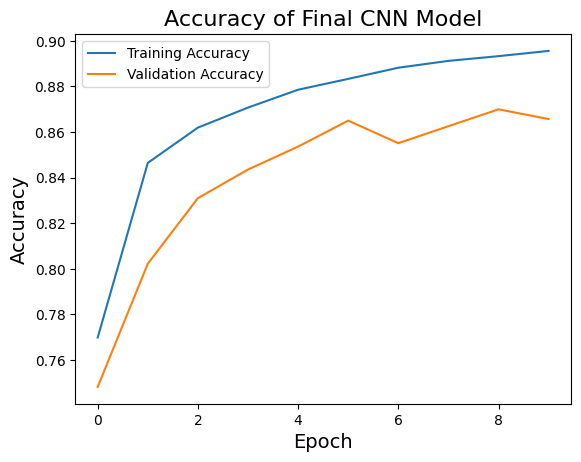

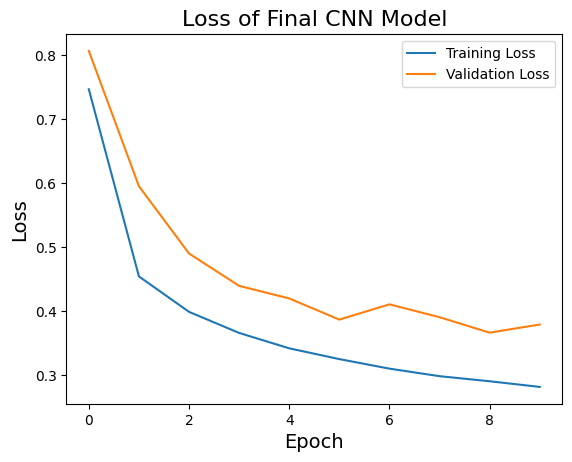

147/147 [==============================] - 1s 10ms/step - loss: 0.3972 - accuracy: 0.8617
Final CNN Model - Test loss: 0.39722496271133423 Test accuracy: 0.8617021441459656
147/147 [==============================] - 2s 9ms/step


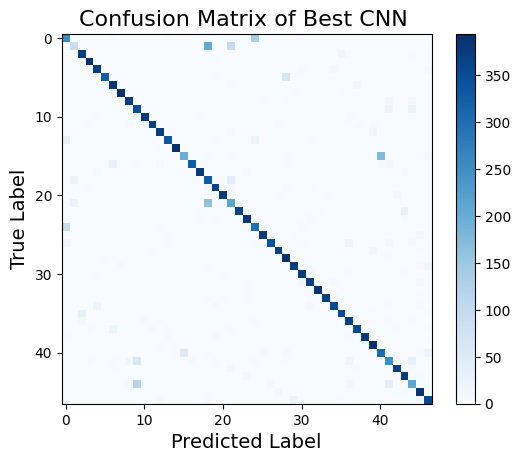

1/1 [==============================] - 0s 120ms/step


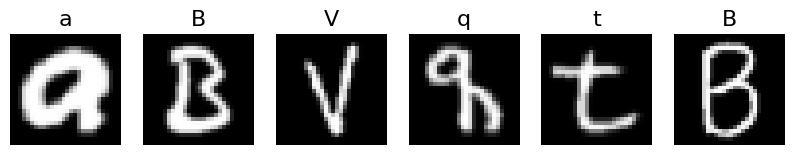

In [17]:
 # Set hyperparameters
learning_rate = 0.01
num_classes = 47
dropout_rate = 0.2

# Final MLP model.
def final_model():
  model = Sequential([
        Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
        BatchNormalization(),
        Dropout(dropout_rate),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, kernel_size=(3,3), activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(47, activation='softmax')])
  return model
# Define learning rate scheduler
# Exponential decay
def exp_decay(epochs):
    initial_lr = 0.1
    decay_rate = 0.1
    lr = initial_lr * np.exp(-decay_rate * epochs)
    return lr
model = final_model()
# Compile model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
# Train MLP model
performance = model.fit(train_data1.batch(128), epochs=10, validation_data = validation_data1.batch(128),
                            callbacks=[LearningRateScheduler(exp_decay), EarlyStopping(patience=5)])

plt.plot(performance.history['accuracy'], label='Training Accuracy')
plt.plot(performance.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy of Final CNN Model")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(performance.history['loss'], label='Training Loss')
plt.plot(performance.history['val_loss'], label='Validation Loss')
plt.title("Loss of Final CNN Model")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the models
test_loss, test_acc = model.evaluate(test_data1.batch(128))
print('Final CNN Model - Test loss:', test_loss, 'Test accuracy:', test_acc)


# Make predictions on the test data
y_pred = model.predict(test_data1.batch(128))
y_pred = np.argmax(y_pred, axis=1) # Convert predictions from probabilities to class labels

# Get true labels from test data
y_true = []
for x, y in test_data1.batch(128):
    y_true.extend(np.argmax(y.numpy(), axis=1))

clf_report=classification_report(y_true, y_pred)
print("Classification report of best MLP model\n", clf_report)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix of Best CNN ')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# Printing 


report=classification_report(y_true, y_pred)

preds = model.predict(test_data.batch(6).take(1))
y_preds = np.argmax(preds, axis=1)
imgs, y_tru = next(iter(test_data.batch(6)))
y_tru_np = y_tru.numpy()
figure = plt.figure(figsize=(10, 10))
for i in range(6):
    figure.add_subplot(1, 6, i+1)
    plt.axis("off")
    img_transpose = imgs[i].T.numpy()
    plt.imshow(img_transpose.squeeze())
    plt.title(chr(mapping[y_tru_np[i]]))
plt.show()

Report of Best model of CNN






In [20]:
clf_report=classification_report(y_true, y_pred)
print("Classification report of best CNN model\n", clf_report)

Classification report of best CNN model
               precision    recall  f1-score   support

           0       0.64      0.64      0.64       400
           1       0.66      0.23      0.34       400
           2       0.88      0.93      0.90       400
           3       0.97      0.98      0.98       400
           4       0.91      0.93      0.92       400
           5       0.98      0.81      0.88       400
           6       0.84      0.96      0.90       400
           7       0.97      0.98      0.97       400
           8       0.91      0.93      0.92       400
           9       0.65      0.87      0.74       400
          10       0.98      0.94      0.96       400
          11       0.97      0.92      0.95       400
          12       0.93      0.93      0.93       400
          13       0.95      0.84      0.89       400
          14       0.98      0.98      0.98       400
          15       0.80      0.49      0.61       400
          16       0.98      0.81      0